In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.model_selection import train_test_split
import hiddenlayer as hl

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import torchtext
from torchtext import data

In [2]:
TEXT = data.Field(include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
fields = [('text', TEXT), ('label', LABEL)]

In [3]:
trainds, testds = data.TabularDataset.splits(path='./data', format='csv', train='train.csv', test='test.csv', fields=fields, skip_header=True)

In [4]:
TEXT.build_vocab(trainds, max_size=2000000, vectors='glove.twitter.27B.50d', unk_init=torch.normal)

In [5]:
LABEL.build_vocab(trainds)

In [6]:
LABEL.vocab.stoi['0'] = 0
LABEL.vocab.stoi['1'] = 1
LABEL.vocab.stoi

defaultdict(None, {'0': 0, '1': 1})

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1024

train_iterator, test_iterator = data.BucketIterator.splits(datasets=(trainds, testds), 
                                                           batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
                                                           sort_key=lambda x: len(x.text), 
                                                           sort_within_batch=True, 
                                                           device=device)

In [8]:
class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(1.0 - self.la_alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [9]:
class SentimentPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings, hidden_dim, output_dim, n_layers, pad_idx, bidirectional):
        super(SentimentPredictor, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Initialize embeddings

        # Define LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=0.8, bidirectional=bidirectional)

        # Final dense
        self.dropout = nn.Dropout(0.8)
        self.dense1 = nn.Linear(hidden_dim * 2, output_dim)
    

    def forward(self, input, lengths):

        embed = self.embedding(input)

        # Pack sequence
        packed_embed = nn.utils.rnn.pack_padded_sequence(embed, lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embed)

        # Take the hidden state of the last layer for output
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        out = self.dense1(hidden)

        return out

In [10]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = len(TEXT.vocab.vectors[0])
PRETRAINED_EMBEDDINGS = TEXT.vocab.vectors
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
BIDIRECTIONAL = True

model = SentimentPredictor(INPUT_DIM, EMBEDDING_DIM, PRETRAINED_EMBEDDINGS, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, PAD_IDX, BIDIRECTIONAL).to(device)

In [11]:
def calculate_accuracy(output, labels):
    preds = torch.round(torch.sigmoid(output))
    correct = (preds == labels).float()
    acc = correct.sum() / len(correct)
    return acc

In [12]:
# Define loss criterion
criterion = nn.BCEWithLogitsLoss()

# Define optimizer
opt = optim.Adam(model.parameters())
opt = Lookahead(optimizer=opt, la_steps=10)

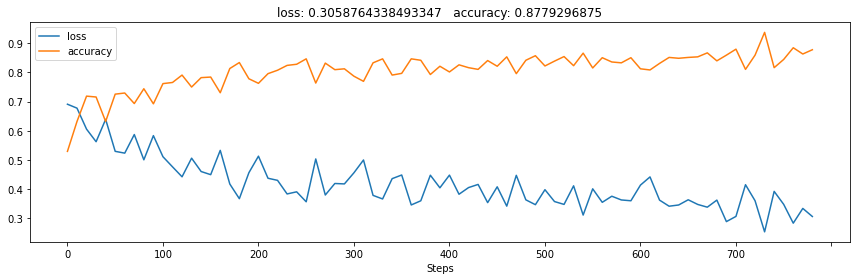

Done!!


In [13]:
history = hl.History()
canvas = hl.Canvas()
EPOCHS = 10
iters = 0

model.train()
# Training loop
for epoch in range(EPOCHS):
    # Iterate over all the batches
    for batch in train_iterator:
        # Reset gradients
        opt.zero_grad()

        # Get the data and lengths from the batch
        data, data_lengths = batch.text

        # Calculate loss and accuracy
        outputs = model(data, data_lengths).squeeze()

        loss = criterion(outputs, batch.label)
        accuracy = calculate_accuracy(outputs, batch.label)

        # Backpropagate the loss
        loss.backward()

        # Update model parameters
        opt.step()

        # Update loss plot every 10th batch
        if iters % 10 == 0:
            history.log(iters, loss=loss, accuracy=accuracy)
            canvas.draw_plot([history['loss'], history['accuracy']])
        iters +=1

print('Done!!')

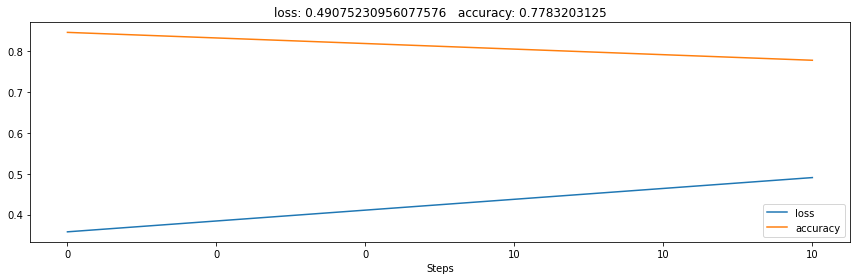

Average accuracy: 0.7864487767219543


In [15]:
test_hist = hl.History()
test_graph = hl.Canvas()
test_iters = 0
preds = np.array([])
labels = np.array([])
acc = []

model.eval()
with torch.no_grad():
    for batch in test_iterator:
        data, data_lengths = batch.text

        opt._backup_and_load_cache()
        outputs = model(data, data_lengths).squeeze()
        preds = np.append(preds, torch.round(torch.sigmoid(outputs)).detach().cpu().numpy())
        labels = np.append(labels, batch.label.detach().cpu().numpy())
        loss = criterion(outputs, batch.label)
        accuracy = calculate_accuracy(outputs, batch.label)
        opt._clear_and_load_backup()
        acc.append(accuracy)

        if test_iters % 10 == 0:
            test_hist.log(test_iters, loss=loss, accuracy=accuracy)
            test_graph.draw_plot([test_hist['loss'], test_hist['accuracy']])
        test_iters += 1
print(f'Average accuracy: {sum(acc) / len(acc)}')

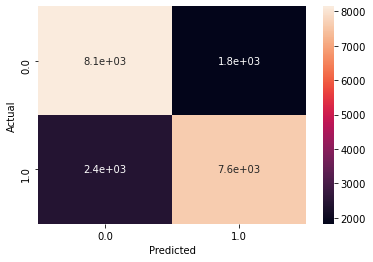

In [16]:
cm_data = {'preds': preds, 'true': labels}
cm_df = pd.DataFrame.from_dict(cm_data)
cm = pd.crosstab(cm_df['true'], cm_df['preds'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(cm, annot=True)
plt.show()

In [21]:
def predict(text):
    #clean_text = clean(text)
    tokenized = [word for word in text.split(' ') if word != '']
    indexed = [TEXT.vocab.stoi[w] for w in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [22]:
predict("took my dog out for a walk, the weather was pretty good")

0.8160519599914551

In [23]:
import pickle

torch.save(model.state_dict(), './twitter_sentiment_state_dict.pt')

model_config = {'stoi' : TEXT.vocab.stoi,
        'input_dim': INPUT_DIM,
        'hidden_dim': HIDDEN_DIM,
        'embedding_dim': EMBEDDING_DIM,
        'output_dim': OUTPUT_DIM,
        'n_layers': N_LAYERS,
        'pad_idx': PAD_IDX}

with open('config.pickle', 'wb') as handle:
    pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)